### 📨 Setup

[source](https://www.kaggle.com/datasets/russellyates88/suicide-rates-overview-1985-to-2016)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
from scipy import stats
from IPython.display import display, Image
import ipywidgets as widgets

df = pd.read_csv("https://drive.google.com/uc?export=download&id=16RNrzOoc8YHisnqD3hxXlW6kX1AElT4O")

In [ ]:
!pip install pycountry-convert==0.7.2
import pycountry_convert as pc

In [ ]:
!pip install -U kaleido
import plotly.express as px
import kaleido

## 📝 Data Preparation

    Starting by a quick look on the head of the dataframe

In [4]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


    Now let's look at the overall information, which is useful for checking data types,
    identifying missing values, and verifying if columns are correctly formatted as integers, strings, etc

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


    The HDI shows a notable lag compared to the other variables

In [6]:
print(df.isnull().sum())

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64


    Well..

In [7]:
print(f"total rows in HDI col: {len(df['HDI for year'])}")

print(f"percentage of real HDI values: {df['HDI for year'].notnull().mean():.2f}")

total rows in HDI col: 27820
percentage of real HDI values: 0.30


    Since 70% of the values in the HDI column are missing, we will drop this column

    Additionally, the 'country-year', 'gdp_for_year ($)' and 'generation' columns will also be removed because they are redundant

In [8]:
df.columns = df.columns.str.strip()
df = df.drop(['HDI for year', 'country-year', 'gdp_for_year ($)', 'generation'], axis=1)

    Are all the non numerical columns really non numerical?

In [9]:
for column in ['country', 'sex', 'age']:
    if df[column].astype(str).apply(lambda x: x.isdigit()).any():
        print(f"The '{column}' column contains numbers.")
    else:
        print(f"The '{column}' column does not contain numbers.")

The 'country' column does not contain numbers.
The 'sex' column does not contain numbers.
The 'age' column does not contain numbers.


    Are all the countries capitalized?

    Are all the genders in lowercase?

In [10]:
print(df['country'].str.istitle().all())
print(df['sex'].str.islower().all())

False
True


    Lets capitalize the countries

In [11]:
df['country'] = df['country'].str.strip().str.title()
print(df['country'].str.istitle().all())

True


    Now that we've finished preparing the data, let's organize it and dive into the analysis

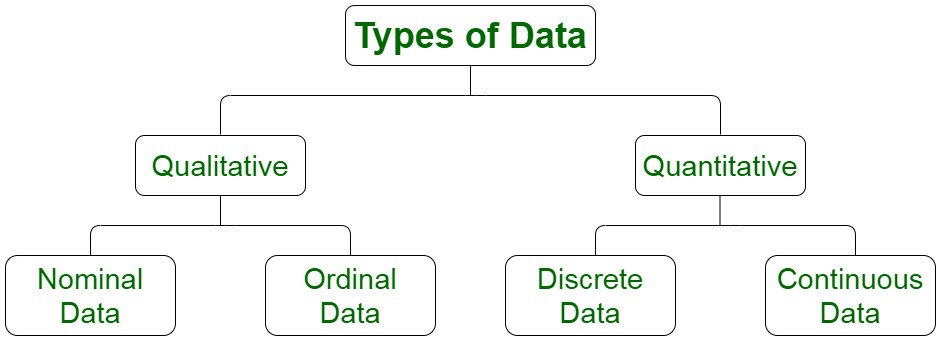

| Header | Data Type | Description |
|---|---|---|
| country | Nominal | Country name, without inherent order. |
| year | Discrete | Year, countable numerical value in discrete intervals. |
| sex | Nominal | Sex of the individual (Male, Female), without inherent order. |
| age | Ordinal | Age in years, countable numerical value in discrete units. |
| suicides_no | Discrete | Number of suicides, countable value in whole units. |
| population | Discrete | Population, countable value in whole units. |
| suicides/100k pop | Continuous | Suicide rate per 100k population, a measure that can take values within a range. |
| gdp_for_year | Continuous | Gross Domestic Product, continuous measure with values within a range. |
| gdp_per_capita | Continuous | GDP per capita, continuous measure with values within a range. |

In [ ]:
# Set non-numerical (qualitative) columns as categorical types
categorical_columns = ['country', 'sex', 'age', 'gdp_for_year ($)']
for col in categorical_columns:
    df[col] = df[col].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   country             27820 non-null  category
 1   year                27820 non-null  int64   
 2   sex                 27820 non-null  category
 3   age                 27820 non-null  category
 4   suicides_no         27820 non-null  int64   
 5   population          27820 non-null  int64   
 6   suicides/100k pop   27820 non-null  float64 
 7   gdp_per_capita ($)  27820 non-null  int64   
dtypes: category(3), float64(1), int64(4)
memory usage: 1.1 MB


    Setting a column data type to category in pandas is good because it saves memory and makes operations faster

## 🔎 Exploratory Data Analysis (EDA)

In [16]:
# this overrides the default plot style and make plots prettier (IMO)
plt.style.use('ggplot')

    Starting with a correlation matrix to quickly identify relationships between variables

[correlation matrix guide](https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html)

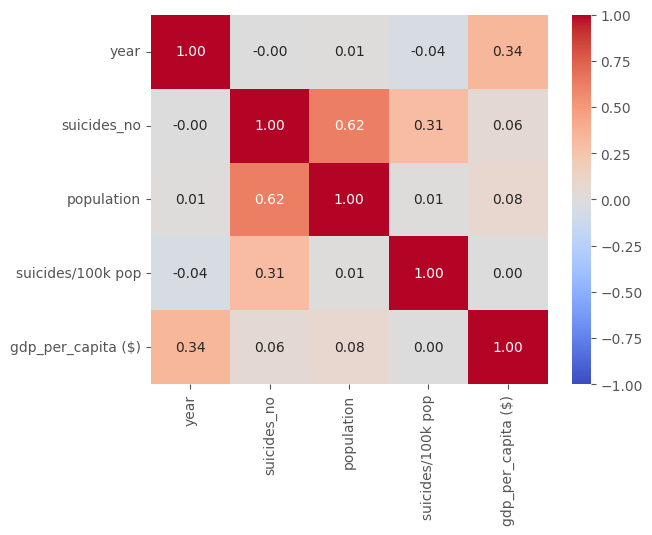

In [17]:
# correlation matrix
cormat = df.corr(numeric_only=True)
cormat = round(cormat, 2)
cormat = cormat.clip(-1, 1)

sns.heatmap(cormat, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

plot_corr = '/content/plot_corr.png'
plt.savefig(plot_corr)

plt.show()

- **year** x **gdp** -> **0.34**  
  Over time, GDP per capita has increased — that is expected as economies generally grow

  ---

- **suicides_no** x **population** -> **0.62**   
  Countries with larger populations naturally tend to have a higher absolute number of suicides

- **suicides_no** x **gdp_per_capita** → **0.06**  
  No strong linear connection between raw suicide counts and GDP per person...

  ---

- **suicides/100k pop** x **gdp** -> **0**  
  Here we see a very weak negative correlation between GDP and suicide rates — it seems like economic wealth is not strongly tied to suicide rates...

- **suicides/100k pop** x **suicides_no** -> **0.31**  
  More suicides tend to mean higher rates, but it's not consistent due to population sizes

  ---

    
    The heatmap gives us a broad view of the dataset, making it easier to catch patterns at a glance

    At the same time, it brings up new questions that we can dig into later

    Continuing with the big-picture analysis, let's start by examining suicide rates across different continents

In [18]:
def country_to_continent(country_name):
    """
    This function takes a country name as input and returns the corresponding continent.
    If the country is not found, it returns 'NaN'.
    """
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except KeyError:
        return 'Error'

df['continent'] = df['country'].apply(country_to_continent)

continent_suicides = df.groupby('continent')['suicides_no'].sum()

continent_suicides = continent_suicides.drop('Error')
continent_suicides = continent_suicides.reset_index()
continent_suicides = continent_suicides.sort_values(by=['suicides_no'], ascending=False)

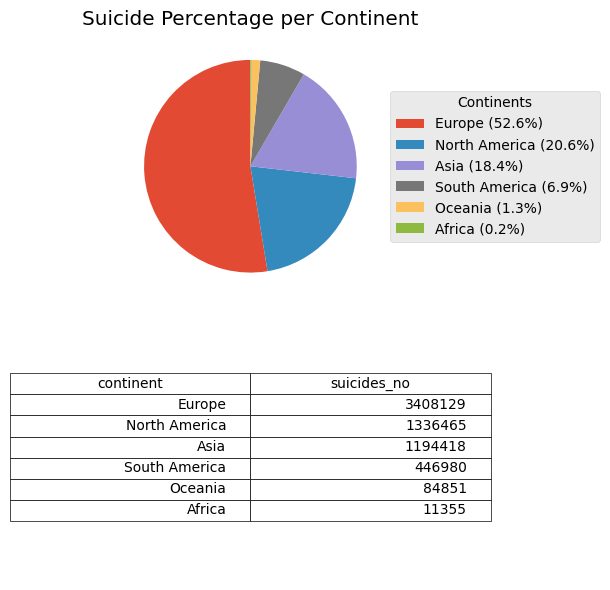

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# ax 0
slices, labels = ax[0].pie(continent_suicides['suicides_no'],
                                       labels=None,
                                       autopct=None,
                                       startangle=90,)

ax[0].legend(
    slices,
    [f"{continent} ({percentage:.1f}%)" for continent, percentage in zip(
        continent_suicides['continent'],
        continent_suicides['suicides_no'] / continent_suicides['suicides_no'].sum() * 100
    )],
    title="Continents",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax[0].set_title('Suicide Percentage per Continent')

# ax 1
ax[1].axis('tight')
ax[1].axis('off')
ax[1].table(cellText=continent_suicides.values, colLabels=continent_suicides.columns, loc='center')

plt.tight_layout()

plot_continent = '/content/plot_continent.png'
plt.savefig(plot_continent)

plt.show()

    More developed countries tend to have a surprisingly higher suicide rate compared to less developed ones

    Let's take a look at the amount of data available for each country

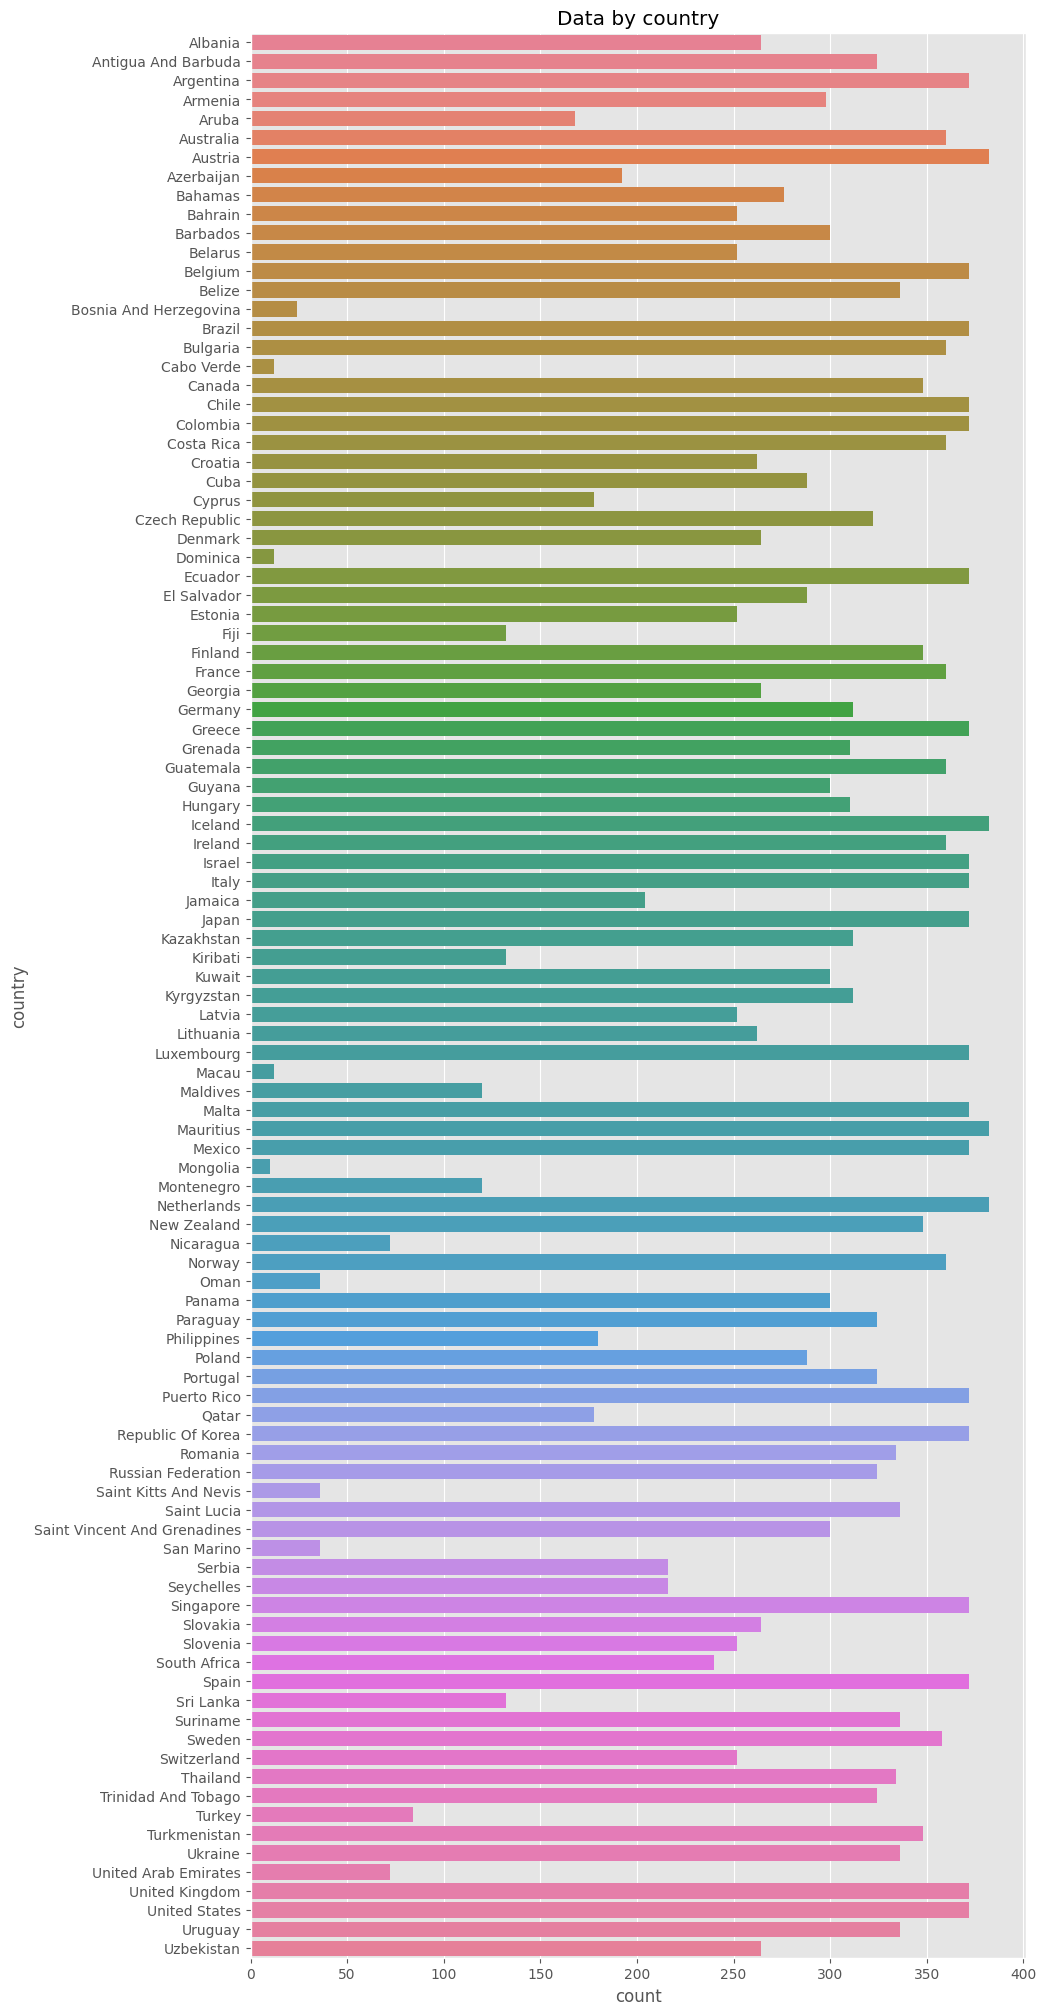

In [20]:
plt.figure(figsize=(10,25))
sns.countplot(y='country', data=df, hue='country')
plt.title('Data by country')

plot_countries = '/content/plot_countries.png'
plt.savefig(plot_countries)

plt.show()

    You've likely noticed the striking disparity in the amount of data available for each country
    
    With that in mind, take the results with a grain of salt, as they are undoubtedly influenced by this inconsistency

In [21]:
df_grouped = df.groupby("country", as_index=False, observed=False)["suicides_no"].sum()

fig = px.choropleth(df_grouped,
                    locations="country",
                    locationmode="country names",
                    color="suicides_no",
                    color_continuous_scale="Reds")

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,

    ),
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.update_traces(
    colorbar_title="Number of Suicides",
    zmin=0,
    zmax=df_grouped["suicides_no"].max(),
    hovertemplate="<b>%{location}</b><br>Suicides: %{z}<extra></extra>"
)

fig.update_geos(

    resolution=50,
    scope="world",
    showcountries=True,
    countrycolor="black",
    showland=True,
    landcolor="lightgray",
)

plot_choropleth = '/content/plot_choropleth.png'
fig.write_image(plot_choropleth)

fig.show()

    (If the map gets distorted, simply drag the cursor to the top-left corner of the choropleth and click 'Reset')

    This map makes it easier to identify which countries have available data and which do not.
    As a result, we see some large areas with significant data gaps. Coupled with the fact that underdeveloped
    countries are less likely to report suicides
    compared to developed ones, this contributes to the noticeable data disparity

    But! There's still an issue with this map: some countries like Russia, the U.S.,
    and Japan are so heavily highlighted that they kind of steal all the attention.
    
    They have such high numbers that they make other countries look almost irrelevant by comparison.

    Take France, for example, it shows up here as
    if it's on the lower end, but when you actually think about it, 300,000 suicides is
    a massive number for a country of its size.

    So, to get a clearer and fairer picture,
    we'll need to make another graph that adjusts for population size too

In [22]:
df_grouped2 = df.groupby("country", as_index=False, observed=False)[["suicides/100k pop", "population"]].sum()


fig = px.choropleth(df_grouped2,
                    locations="country",
                    locationmode="country names",
                    color="suicides/100k pop",
                    color_continuous_scale="Reds")

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
    ),
    margin={"r":0,"t":0,"l":0,"b":0}
)

fig.update_traces(
    colorbar_title="Suicide Rate<br>per 100k Population",
    zmin=0,
    zmax=df_grouped2["suicides/100k pop"].max(),
    hovertemplate="<b>%{location}</b><br>Suicide Rate: %{z:.2f} per 100k<extra></extra>"
)

fig.update_geos(
    resolution=50,
    scope="world",
    showcountries=True,
    countrycolor="black",
    showland=True,
    landcolor="lightgray",
)

plot_choropleth2 = '/content/plot_choropleth2.png'
fig.write_image(plot_choropleth2)

fig.show()

    And as you can see, the colors shift dramatically when we account for population density.
    Looking again at France, it's clear that it's a much more concerning case than it first appeared.

## 🤿 Diving In

    From the correlation matrix, we observed that GDP doesn't seem to have a strong correlation with suicide rates
    
    Let's dive deeper into this and investigate further

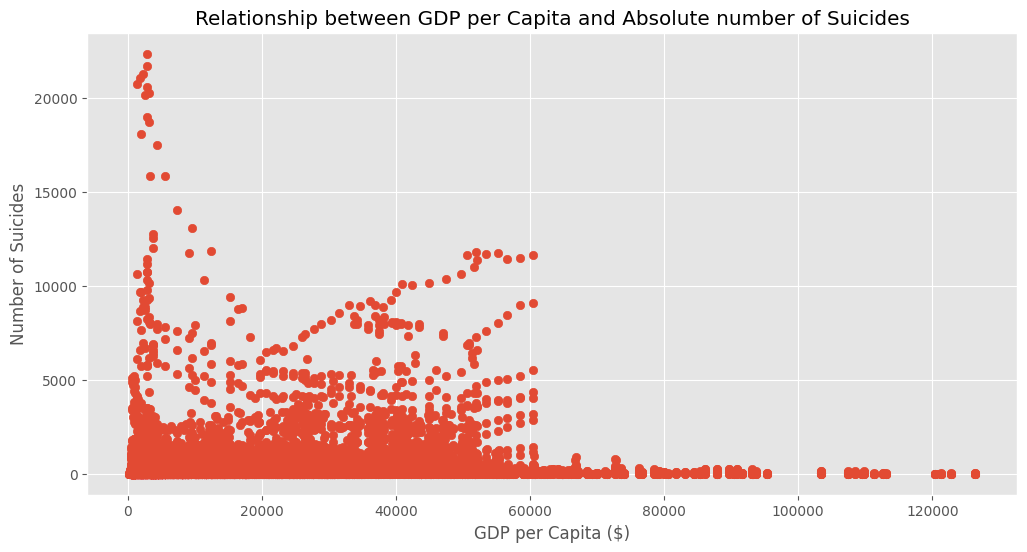

In [23]:
plt.figure(figsize=(12, 6))

plt.scatter(df['gdp_per_capita ($)'], df['suicides_no'])
plt.xlabel('GDP per Capita ($)')
plt.ylabel('Number of Suicides')
plt.title('Relationship between GDP per Capita and Absolute number of Suicides')

plot_scat_suicide_gdp = '/content/plot_scat_suicide_gdp.png'
plt.savefig(plot_scat_suicide_gdp)

plt.show()

    Although the graph might look a bit messy at first, we can still spot a
    clear trend: in general, the higher the GDP, the lower the suicide rates.
    
    But we can make this even easier to see, let's group the GDP
    values into ranges (or bins) and calculate the average suicide rate
    for each group. That way, the pattern will stand out much more clearly.

In [24]:
bins = [0, 20000, 40000, 60000, 80000, 100000, 120000]
labels = ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k-120k']

df['gdp_bin'] = pd.cut(df['gdp_per_capita ($)'], bins=bins, labels=labels, include_lowest=True)

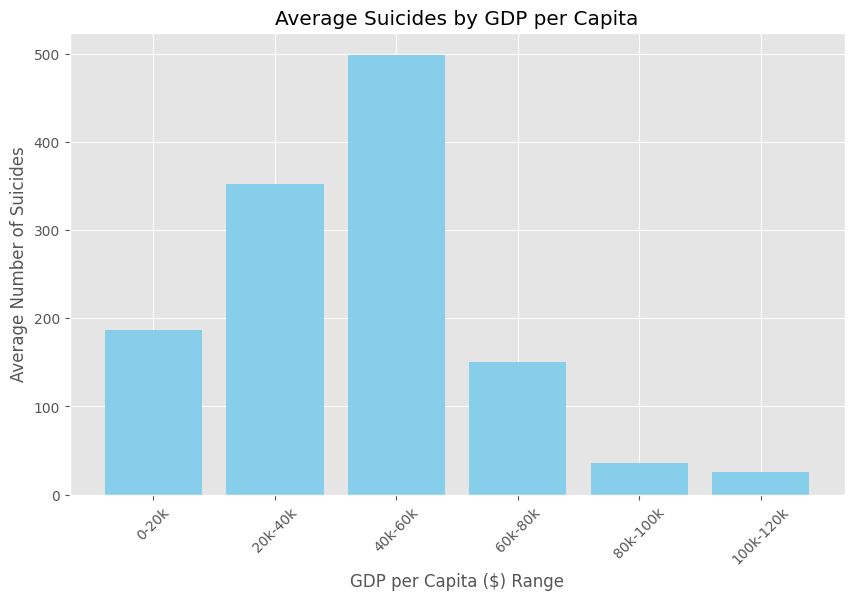

In [25]:
gdp_suicides = df.groupby('gdp_bin', observed=False)['suicides_no'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(gdp_suicides['gdp_bin'], gdp_suicides['suicides_no'], color='skyblue')
plt.xlabel('GDP per Capita ($) Range')
plt.ylabel('Average Number of Suicides')
plt.title('Average Suicides by GDP per Capita')
plt.xticks(rotation=45)

plot_bar_suicide_gdp = '/content/plot_bar_suicide_gdp.png'
plt.savefig(plot_bar_suicide_gdp)

plt.show()

    Now that we've grouped the data and got the mean for each GDP range,
    the outliers aren't messing things up as much,
    even though they probably still pull the data a little.
    
    But look at how the trend changed: instead of a simple decrease,
    we can now see that from $0k to $60k, the suicide numbers actually
    increase with GDP.
    It's only after $60k that the numbers start to go down.
    Pretty unexpected, right?

    In this next analysis, we chose to use the suicide rate instead of the absolute
    number of suicides, and we've also color-coded the data by gender
    
    This should allow us to observe a more consistent trend

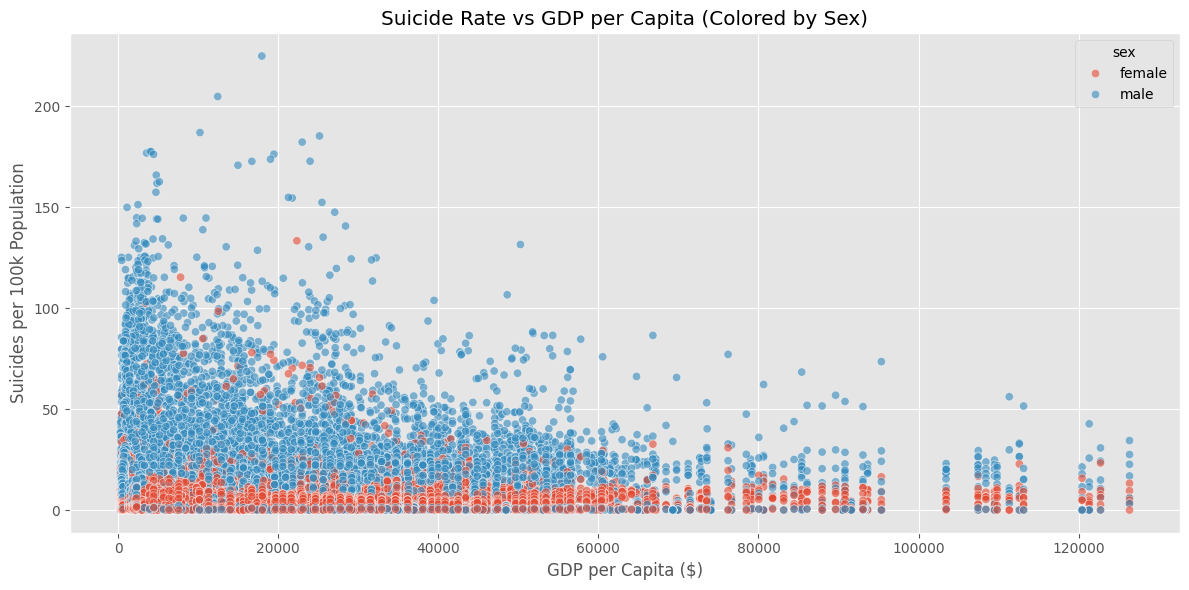

In [40]:
plt.figure(figsize=(12, 6))

sns.scatterplot(
    x='gdp_per_capita ($)',
    y='suicides/100k pop',
    hue='sex',


    alpha=0.6,
    data=df
)

plt.title('Suicide Rate vs GDP per Capita (Colored by Sex)')
plt.xlabel('GDP per Capita ($)')
plt.ylabel('Suicides per 100k Population')
plt.tight_layout()

plot_rate_gdp = '/content/plot_rate_gdp.png'
plt.savefig(plot_rate_gdp)

plt.show()

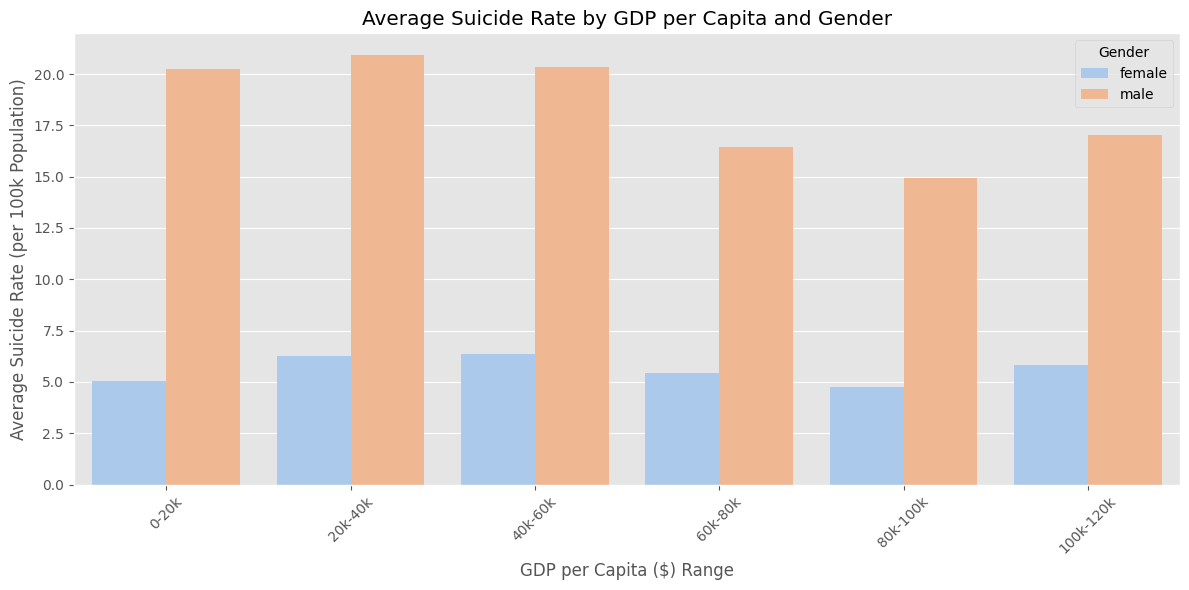

In [27]:
gdp_suicides_gender = df.groupby(['gdp_bin', 'sex'], observed=False)['suicides/100k pop'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x='gdp_bin',
    y='suicides/100k pop',
    hue='sex',
    data=gdp_suicides_gender,
    palette='pastel'
)

plt.xlabel('GDP per Capita ($) Range')
plt.ylabel('Average Suicide Rate (per 100k Population)')
plt.title('Average Suicide Rate by GDP per Capita and Gender')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()

plot_bar_srate_gdp = '/content/plot_bar_srate_gdp.png'
plt.savefig(plot_bar_srate_gdp)

plt.show()

    Well.. This is surprising, the scatter graph displayed a much smoother trend
    downwards, but then, now getting the mean, it seems that both the two genders
    follow a wave pattern throughout all the GDP ranges.

    Additionally, the number of male suicides is significantly
    higher compared to female suicides, which warrants further examination
    

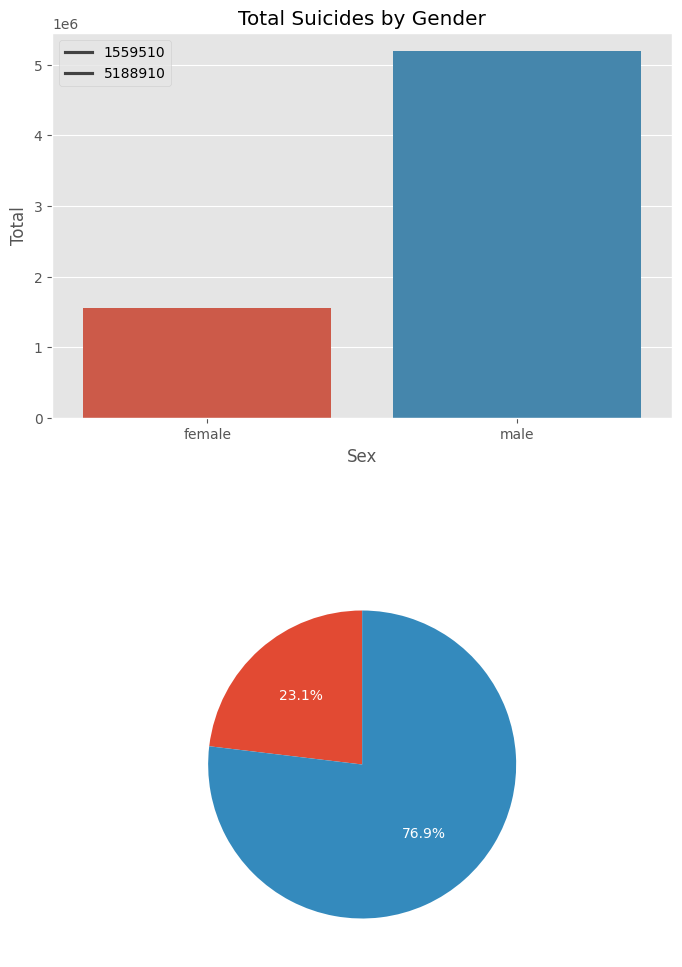

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12), gridspec_kw={'hspace': 0.4})

sex_suicides = df.groupby('sex', observed=False)['suicides_no'].sum()

sns.barplot(x=sex_suicides.index, y=sex_suicides.values, hue=sex_suicides.index, ax=ax[0])
ax[0].set_title('Total Suicides by Gender')
ax[0].set_xlabel('Sex')
ax[0].set_ylabel('Total')
ax[0].legend(sex_suicides)


ax[1].pie(sex_suicides, labels=sex_suicides.index, autopct='%1.1f%%', startangle=90, textprops={'color': "w"})

plot_gender = '/content/plot_gender.png'
plt.savefig(plot_gender)

plt.show()


    In fact, the number of male suicides is more than three times higher than the number of female suicides
    
    Has this always been the case?

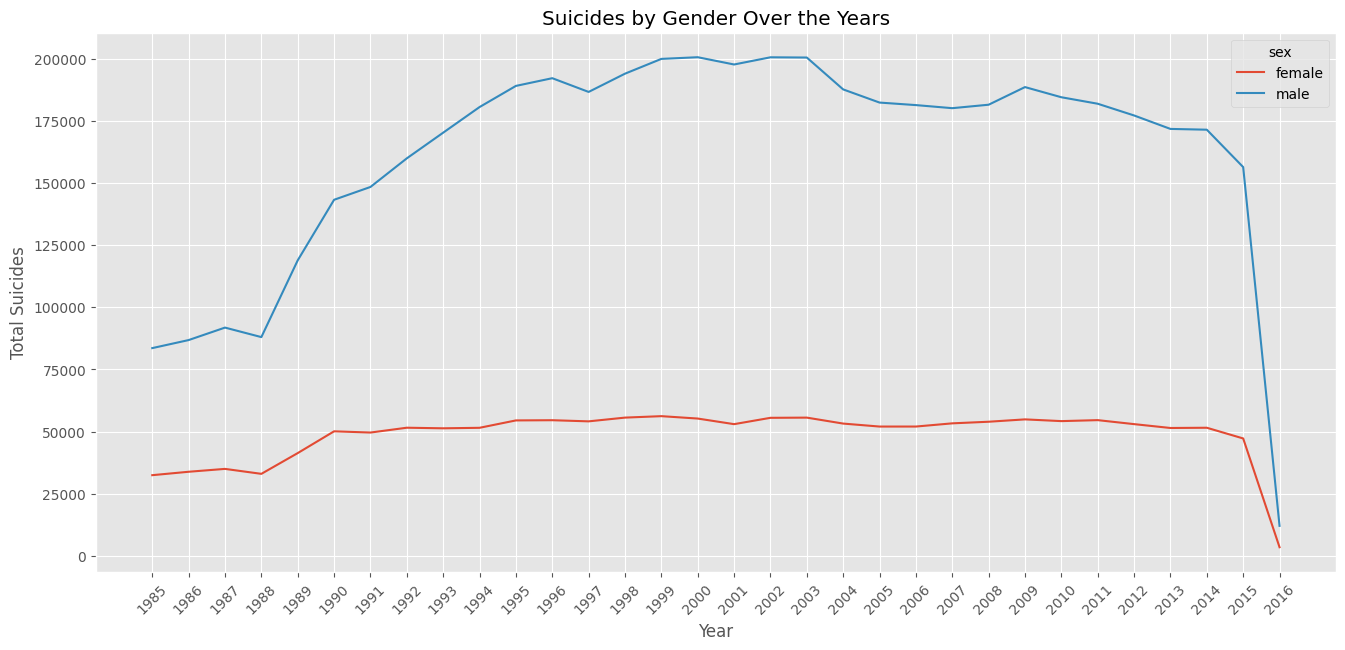

In [29]:
gender_yearly_suicides = df.groupby(['year', 'sex'], observed=False)['suicides_no'].sum().reset_index()

plt.figure(figsize=(16, 7))
sns.lineplot(x='year', y='suicides_no', hue='sex', data=gender_yearly_suicides)
plt.title('Suicides by Gender Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Suicides')

plt.xticks(range(gender_yearly_suicides['year'].min(), gender_yearly_suicides['year'].max() + 1), rotation=45)

plot_gender_years = '/content/plot_gender_years.png'
plt.savefig(plot_gender_years)

plt.show()

    Yes, it has always been the case, but why the sudden spike after 1988? And what's behind the sharp decline in 2016?
    
    Not that I'm complaining about the decrease in suicides, but from an analytical standpoint, it's definitely curious 🙂

    Lets see the total suicides, without gender separations now

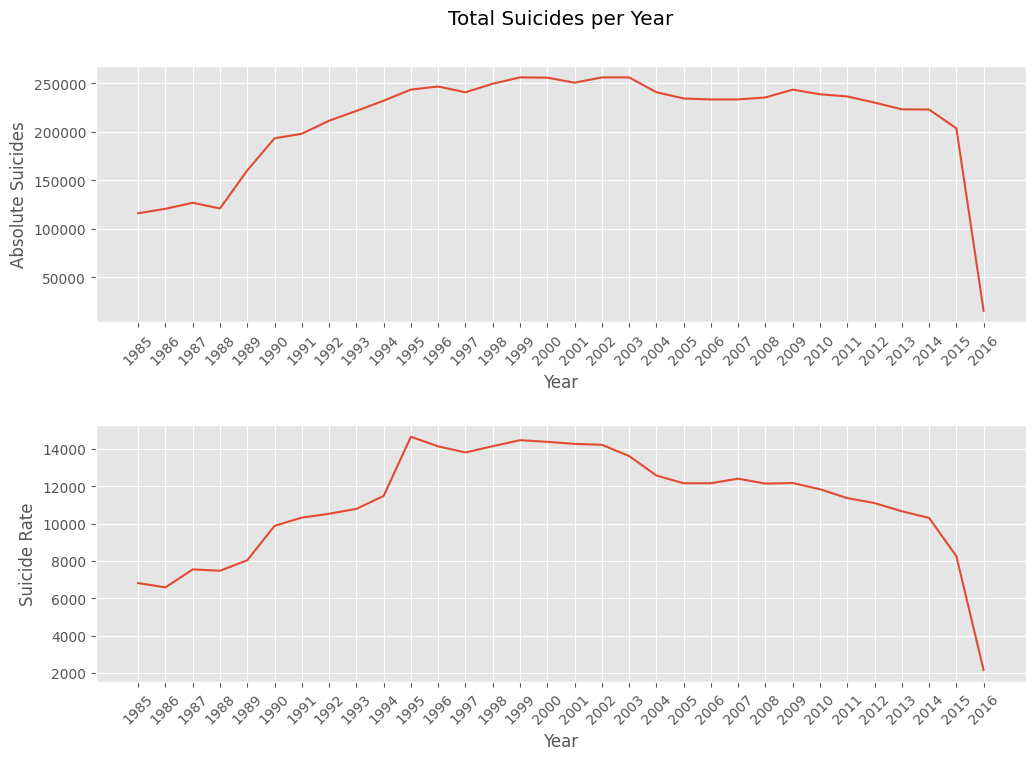

In [30]:
total_suicides_data = df.groupby('year').agg(
    total_suicides=('suicides_no', 'sum'),
    suicide_rate=('suicides/100k pop', 'sum')
    ).reset_index()

# ----------

fig, axes_ticklabels_overlap = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.4})

# Plot for total suicides per year
sns.lineplot(x='year', y='total_suicides', data=total_suicides_data, ax=axes_ticklabels_overlap[0])
axes_ticklabels_overlap[0].set_title('Total Suicides per Year', pad=30)
axes_ticklabels_overlap[0].set_xlabel('Year')
axes_ticklabels_overlap[0].set_ylabel('Absolute Suicides')
axes_ticklabels_overlap[0].set_xticks(range(total_suicides_data['year'].min(), total_suicides_data['year'].max() + 1))
axes_ticklabels_overlap[0].tick_params(axis='x', rotation=45)

# Plot for suicide rate per year
sns.lineplot(x='year', y='suicide_rate', data=total_suicides_data, ax=axes_ticklabels_overlap[1])
axes_ticklabels_overlap[1].set_xlabel('Year')
axes_ticklabels_overlap[1].set_ylabel('Suicide Rate')
axes_ticklabels_overlap[1].set_xticks(range(total_suicides_data['year'].min(), total_suicides_data['year'].max() + 1))
axes_ticklabels_overlap[1].tick_params(axis='x', rotation=45)


plot_suicide_years = '/content/plot_suicide_years.png'
plt.savefig(plot_suicide_years)

plt.show()

    Although they are slightly different, both follow the same overall trend

    Now that we've seen the overall trends in suicides and suicide rates over the years, let’s dive deeper into the statistics
    
    We'll look at a more granular view of suicide data by examining key statistical measures:
    the mean, median, standard deviation, as well as the minimum and maximum values for each year
    
    This analysis will help us better understand the distribution of suicides over
    time, the degree of variation, and any anomalies or spikes that stand out

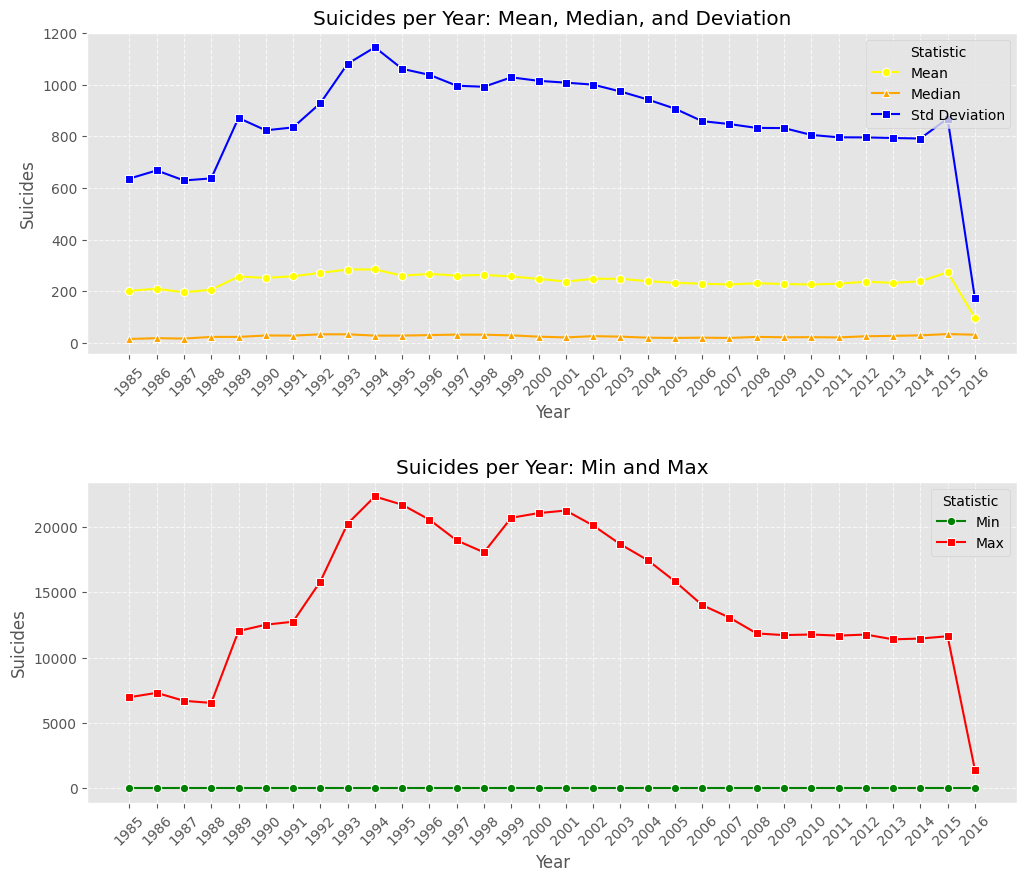

In [31]:
stats_suicides_year = df.groupby('year')['suicides_no'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'hspace': 0.4})

# First plot: Mean, Median, and Std Dev
sns.lineplot(x='year', y='mean', data=stats_suicides_year, label='Mean', color='yellow', marker='o', ax=axes[0])
sns.lineplot(x='year', y='median', data=stats_suicides_year, label='Median', color='orange', marker='^', ax=axes[0])
sns.lineplot(x='year', y='std', data=stats_suicides_year, label='Std Deviation', color='blue', marker='s', ax=axes[0])

axes[0].set_title('Suicides per Year: Mean, Median, and Deviation')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Suicides')
axes[0].set_xticks(stats_suicides_year['year'])
axes[0].set_xticklabels(stats_suicides_year['year'], rotation=45)
axes[0].legend(title='Statistic', loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Second plot: Min and Max
sns.lineplot(x='year', y='min', data=stats_suicides_year, label='Min', color='green', marker='o', ax=axes[1])
sns.lineplot(x='year', y='max', data=stats_suicides_year, label='Max', color='red', marker='s', ax=axes[1])

axes[1].set_title('Suicides per Year: Min and Max')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Suicides')
axes[1].set_xticks(stats_suicides_year['year'])
axes[1].set_xticklabels(stats_suicides_year['year'], rotation=45)
axes[1].legend(title='Statistic', loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.7)


plot_stats = '/content/plot_stats.png'
plt.savefig(plot_stats)


plt.show()


    The median remains close to zero, fluctuating within a small range across all years, which indicates that the majority
    of countries or regions report low numbers of suicides.
    This suggests that the majority of the dataset might be dominated by countries with relatively low suicide rates.

    The mean consistently stays between 200 and 400 suicides per year, which is much higher than the median.
    This could indicate that there are outliers (countries with high suicide rates)
    that are pulling the average up, while most countries have relatively few suicides.

    The standard deviation starts at 600, which is fairly high, and continues to rise until it peaks around 1200 in 1994.
    This sharp increase in deviation could be linked to a major event or crisis in the early 90s
    that caused a significant fluctuation in suicide rates across different countries.

    The subsequent gradual decline in standard deviation after 1994 suggests that the variation between countries
    suicide rates started to stabilize, with fewer extreme fluctuations in the following years.
    This could be interpreted as a greater homogenization of suicide rates globally, potentially due to better reporting systems
    or more consistent socio-economic factors.    

    In 2016, there's a noticeable dip in all three measures (mean, median, and standard deviation) to below 200.
    This could indicate a significant decrease in global suicides in that year, or
    it may reflect a change in reporting practices, data collection, or significant improvements in
    mental health awareness and intervention programs.


---


    The minimum number of suicides remains at zero for the entire period, indicating that in some years,
    certain countries or regions reported no suicides. This could be due to underreporting, lack of data collection in
    some countries, or a lack of suicides being registered in certain areas.
    This is particularly common in smaller countries or regions with less-developed reporting systems.

    The maximum number of suicides starts around 7,000 in the mid-1980s and rises sharply to approximately 23,000 by 1994.
    This sharp increase in suicides could correspond to a global crisis, such as an economic recession or
    significant political upheaval in certain countries during that time
    (e.g., the collapse of the Soviet Union, or economic struggles in specific regions)

    After the peak in 1994, the maximum number of suicides begins to gradually decrease,
    falling back down to around 11,000 by 2014.
    This decline suggests that the extreme values (outliers) became less pronounced.
    Several factors could explain this, such as improvements in mental health awareness,
    better data collection practices, or economic stabilization in regions that were previously experiencing high suicide rates.


---


    Let's take a closer look at the 1994 peak and 2016 dip



In [32]:
max_suicide_row = df.loc[df['suicides_no'].idxmax()]
for column, value in max_suicide_row.items():
    print(f"{column}: {value}")

country: Russian Federation
year: 1994
sex: male
age: 35-54 years
suicides_no: 22338
population: 19044200
suicides/100k pop: 117.3
gdp_per_capita ($): 2853
continent: Europe
gdp_bin: 0-20k


    Discussing the collapse of the Soviet Union, the peak in 1994 occurred in the
    Russian Federation, a period marked by severe economic instability and mental health crises.
[collapse of the Soviet Union](https://history.state.gov/milestones/1989-1992/collapse-soviet-union)

[first checken war](https://www.voanews.com/a/first-chechen-war-the-moment-when-russia-s-democratic-post-soviet-dream-ended-/7899845.html)
    
    This era was characterized by political violence, and social upheaval, which likely
    contributed to the significant rise in suicides.
    
    Additionally, it is noteworthy that
    the 35-54 age group was particularly affected

    Just a feeling based on what we'seem until now, but what if the dip was just a big lack of data?

In [33]:
print(df['year'].value_counts().sort_index())

year
1985     576
1986     576
1987     648
1988     588
1989     624
1990     768
1991     768
1992     780
1993     780
1994     816
1995     936
1996     924
1997     924
1998     948
1999     996
2000    1032
2001    1056
2002    1032
2003    1032
2004    1008
2005    1008
2006    1020
2007    1032
2008    1020
2009    1068
2010    1056
2011    1032
2012     972
2013     960
2014     936
2015     744
2016     160
Name: count, dtype: int64


    🤡

    Sure, back to the age

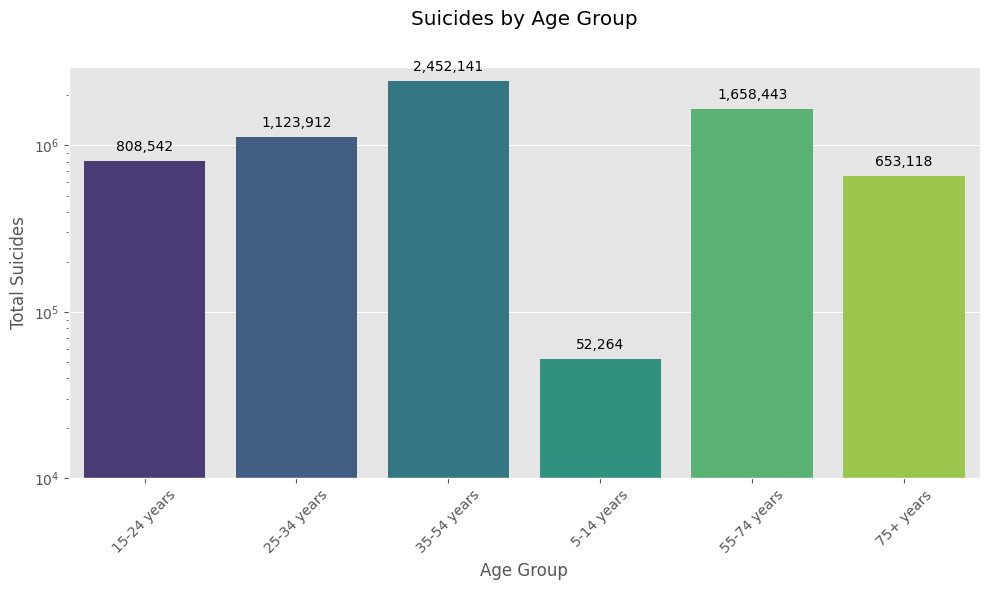

In [34]:
age_suicide = df.groupby('age', observed=False)['suicides_no'].sum().reset_index()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='age', y='suicides_no', data=age_suicide, palette='viridis', hue='age')

plt.title('Suicides by Age Group', pad=30)
plt.xlabel('Age Group')
plt.ylabel('Total Suicides')

plt.yscale('log')
plt.yticks([10**4, 10**5, 10**6])

plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 10), textcoords='offset points')

plt.tight_layout()


plot_age = '/content/plot_age.png'
plt.savefig(plot_age)


plt.show()

    It seems that not only during the peak in 1994, but overall, the 35-54 age group is the demographic
    with the highest suicide rates. Again, has it always been like that?

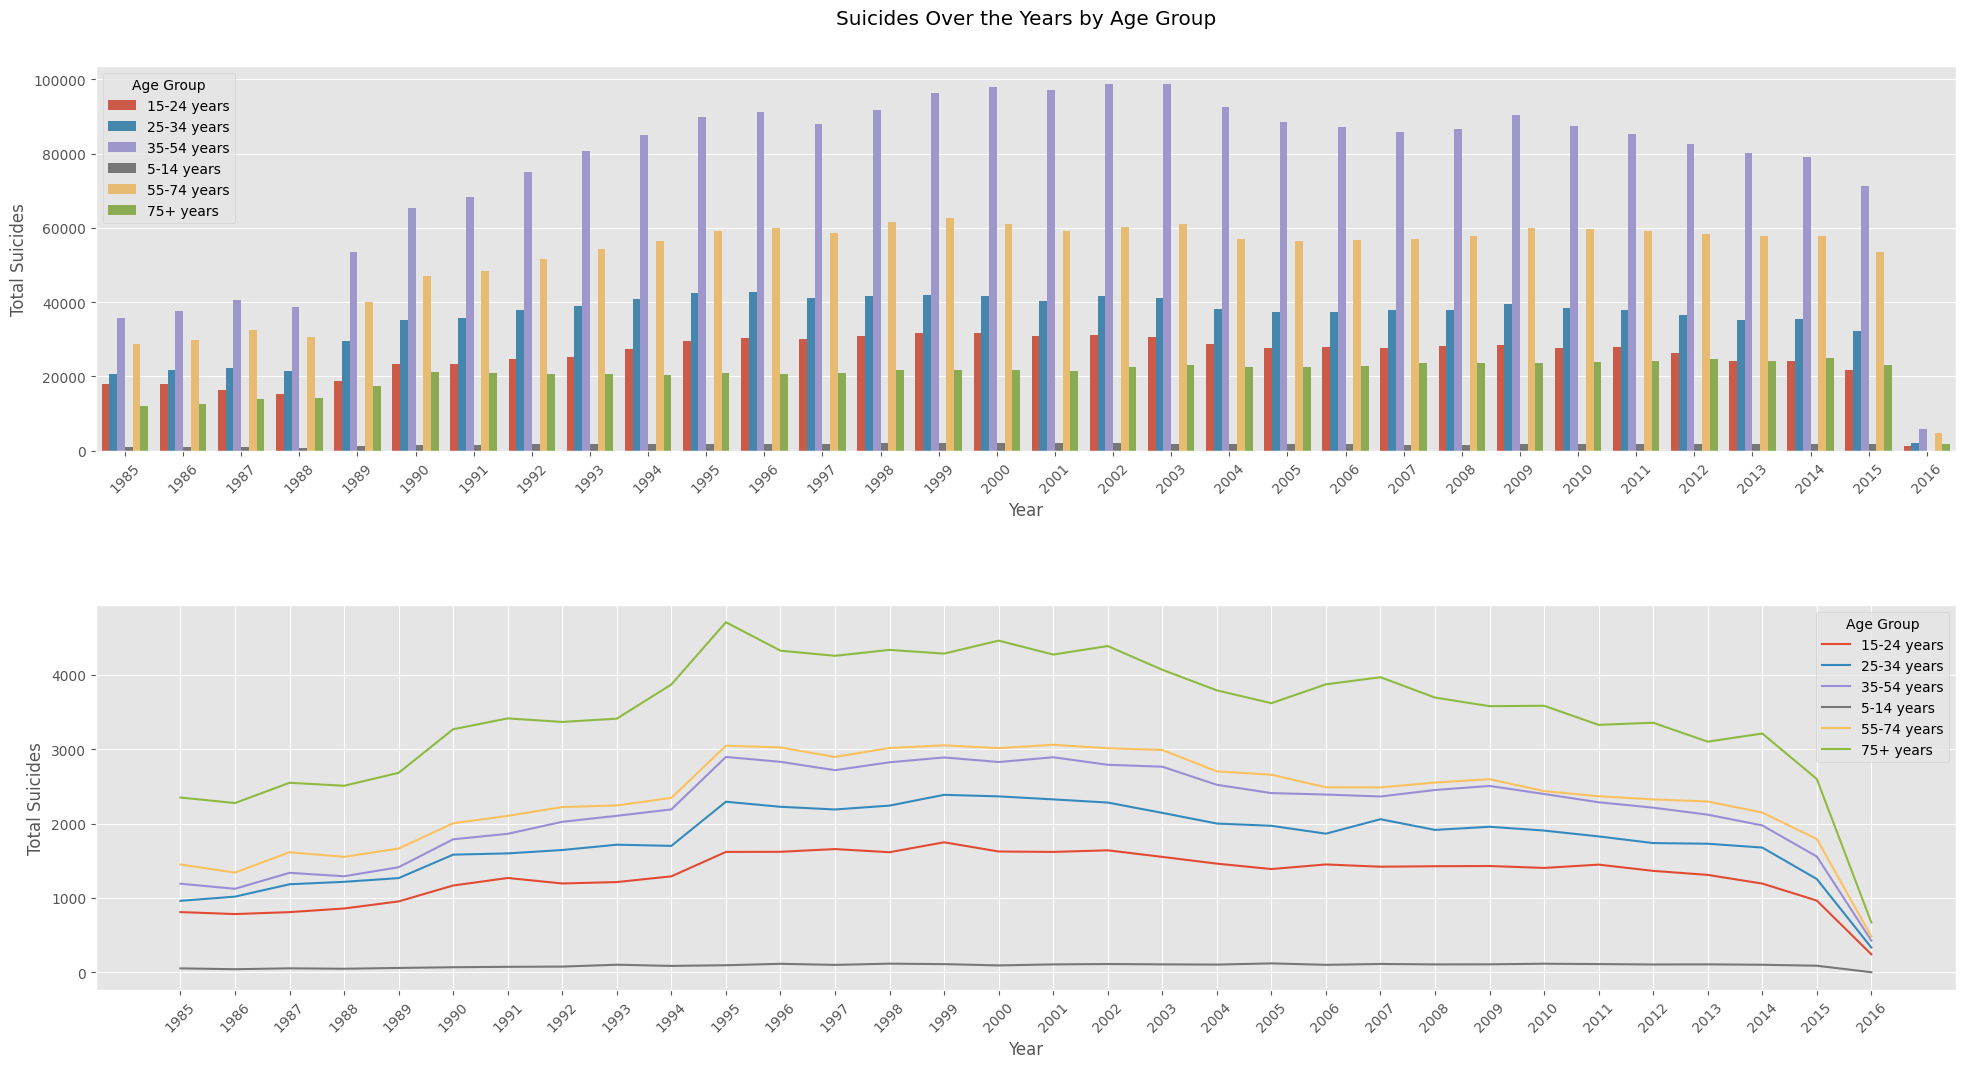

In [46]:
suicides_by_year_age = df.groupby(['year', 'age'], observed=False)[['suicides_no', 'suicides/100k pop']].sum().reset_index() # Changed tuple to list

fig, axes = plt.subplots(2, 1, figsize=(24, 12), gridspec_kw={'hspace': 0.4})
axes = axes.flatten()

# Bar Plot
sns.barplot(x='year', y='suicides_no', hue='age', data=suicides_by_year_age, ax=axes[0])
axes[0].set_title('Suicides Over the Years by Age Group', pad=30)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Suicides')
axes[0].legend(title='Age Group')
axes[0].tick_params(axis='x', rotation=45)

# Line Plot
sns.lineplot(x='year', y='suicides/100k pop', hue='age', data=suicides_by_year_age, ax=axes[1])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Suicides')
axes[1].set_xticks(suicides_by_year_age['year'].unique())
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Age Group')


plot_age_years = '/content/plot_age_years.png'
plt.savefig(plot_age_years)


plt.show()

    Yes. This group consistently shows the highest number of suicides across the years

## 📌 Conclusion

    reference at the bottom

### **Overall Suicide Trends**
    reference: Statistical Analysis on Suicide over the years

- We observed a significant increase in suicides in 1994, particularly in the Russian Federation, which can be attributed to the collapse of the Soviet Union, economic instability, political violence, and mental health crisis

- Over the years, suicides generally followed a fluctuating trend, with a noticeable dip in 2016 that turned out to be largely due to missing data, rather than a real trend

### **Age Group Analysis**
    reference: Total Suicides by Age;
               Suicide by age over the years

- The 35-54 age group has consistently had the highest suicide rates. This demographic was particularly impacted during the 1994 peak, but the trend has remained significant over the years, raising important questions about the socio-economic pressures, work-related stress, and other factors contributing to higher suicide rates in this age group.

### **Gender Disparities**
    reference: Total suicides by Gender;
               Total suicides by Gender Over the years

- A striking disparity was found between male and female suicides, with males having over three times more suicides than females. This gender gap remained large throughout the years, suggesting that targeted mental health interventions for men may be crucial in addressing this issue.

### **Suicide Rates and Economic Factors**
    reference: Sucide x GDP;
               Suicide Rate X GDP

- Initially, plotting raw suicide numbers against GDP suggested a downward
trend, but after grouping countries into income bins, we discovered a more complex pattern: suicide rates peaked in medium-GDP regions and decreased toward higher GDP levels.
- When switching from total numbers to suicide rates instead, the trend became even more interesting — it resembled a waveform, with lower rates at the lowest GDP levels, rising toward the middle, dipping slightly, and then rising again among the highest-income countries.
- One possible explanation could be the combined effects of resource scarcity at low incomes, rising stress at middle incomes, and extremely high-pressure environments at the top.

### **Data Limitations**
    reference: Suicides by Continent;
               Suicides by Country;
               World Map

- A critical limitation of the dataset is the uneven distribution of data across countries, particularly in underdeveloped countries where suicides may be underreported. This gap must be considered when interpreting global suicide trends.  

    
    In conclusion, while the global suicide trend shows signs of fluctuation, understanding the underlying socio-economic,
    political, and gender-related factors is essential in developing targeted strategies to reduce suicides.
    The importance of addressing mental health and improving economic conditions cannot be overstated,
    and more focus should be placed on regions and demographics that remain most affected.

## 🧐 Reference

In [47]:
def show_plot(path):
    display(Image(filename=path))


button1 = widgets.Button(description="Correlation Matrix", layout=widgets.Layout(width='400px'))
button2 = widgets.Button(description="Suicides by Continent", layout=widgets.Layout(width='400px'))
button3 = widgets.Button(description="Suicides by Country", layout=widgets.Layout(width='400px'))
button4 = widgets.Button(description="Suicides World Map", layout=widgets.Layout(width='400px'))
button5 = widgets.Button(description="Suicide Rate World Map", layout=widgets.Layout(width='400px'))
button6 = widgets.Button(description="Suicide X GDP (scatter)", layout=widgets.Layout(width='400px'))
button7 = widgets.Button(description="Suicide X GDP (bar mean)", layout=widgets.Layout(width='400px'))
button8 = widgets.Button(description="Suicide Rate X GDP", layout=widgets.Layout(width='400px'))
button9 = widgets.Button(description="Suicide Rate X GDP", layout=widgets.Layout(width='400px'))
button10 = widgets.Button(description="Total suicides by Gender", layout=widgets.Layout(width='400px'))
button11 = widgets.Button(description="Total suicides by Gender Over the Years", layout=widgets.Layout(width='400px'))
button12 = widgets.Button(description="Total suicides over the years", layout=widgets.Layout(width='400px'))
button13 = widgets.Button(description="Statistical Analysis on Suicide over the years", layout=widgets.Layout(width='400px'))
button14 = widgets.Button(description="Total Suicides by Age", layout=widgets.Layout(width='400px'))
button15 = widgets.Button(description="Suicide by age over the years", layout=widgets.Layout(width='400px'))

button1.on_click(lambda x: show_plot(plot_corr))
button2.on_click(lambda x: show_plot(plot_continent))
button3.on_click(lambda x: show_plot(plot_countries))
button4.on_click(lambda x: show_plot(plot_choropleth))
button5.on_click(lambda x: show_plot(plot_choropleth2))
button6.on_click(lambda x: show_plot(plot_scat_suicide_gdp))
button7.on_click(lambda x: show_plot(plot_bar_suicide_gdp))
button8.on_click(lambda x: show_plot(plot_rate_gdp))
button9.on_click(lambda x: show_plot(plot_bar_srate_gdp))
button10.on_click(lambda x: show_plot(plot_gender))
button11.on_click(lambda x: show_plot(plot_gender_years))
button12.on_click(lambda x: show_plot(plot_suicide_years))
button13.on_click(lambda x: show_plot(plot_stats))
button14.on_click(lambda x: show_plot(plot_age))
button15.on_click(lambda x: show_plot(plot_age_years))

    OBS: dont spam, pick one, clear, pick another

In [48]:
display(button1,
        button2,
        button3,
        button4,
        button5,
        button6,
        button7,
        button8,
        button9,
        button10,
        button11,
        button12,
        )

Button(description='Correlation Matrix', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicides by Continent', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicides by Country', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicides World Map', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicide Rate World Map', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicide X GDP (scatter)', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicide X GDP (bar mean)', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicide Rate X GDP', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Suicide Rate X GDP', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Total suicides by Gender', layout=Layout(width='400px'), style=ButtonStyle())

Button(description='Total suicides by Gender Over the Years', layout=Layout(width='400px'), style=ButtonStyle(…

Button(description='Total suicides over the years', layout=Layout(width='400px'), style=ButtonStyle())